In [1]:
# To help with reading and manipulation of data
import numpy as np
import pandas as pd
import pprint

# To help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# To split the data
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

# to create k folds of data and get cross validation score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# to create pipeline and make_pipeline
from sklearn.pipeline import Pipeline, make_pipeline

# to use standard scaler
from sklearn.preprocessing import StandardScaler

# To impute missing values
from sklearn.impute import SimpleImputer

# To build a Random forest classifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier

# To tune a model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

# To get different performance metrics
import sklearn.metrics as metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    recall_score,
    accuracy_score,
    precision_score,
    f1_score,
)

# To undersample and oversample the data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


# To suppress warnings
import warnings

In [2]:
data = pd.Series([1, 1, 6, 13, 13, 14, 14, 15, 15, 16, 18, 18, 18, 19, 100, 300], name="feature")
target = pd.Series([1, 2, 5, 15, 13, 18, 14, 15, 14, 16, 18, 18, 18, 25, 30, 14], name="target")
main_data = pd.concat([data, target], axis=1).reset_index()
main_data.drop("index", axis=1, inplace=True)
main_data.head(10)

,feature,target
0,1,1
1,1,2
2,6,5
3,13,15
4,13,13
5,14,18
6,14,14
7,15,15
8,15,14
9,16,16


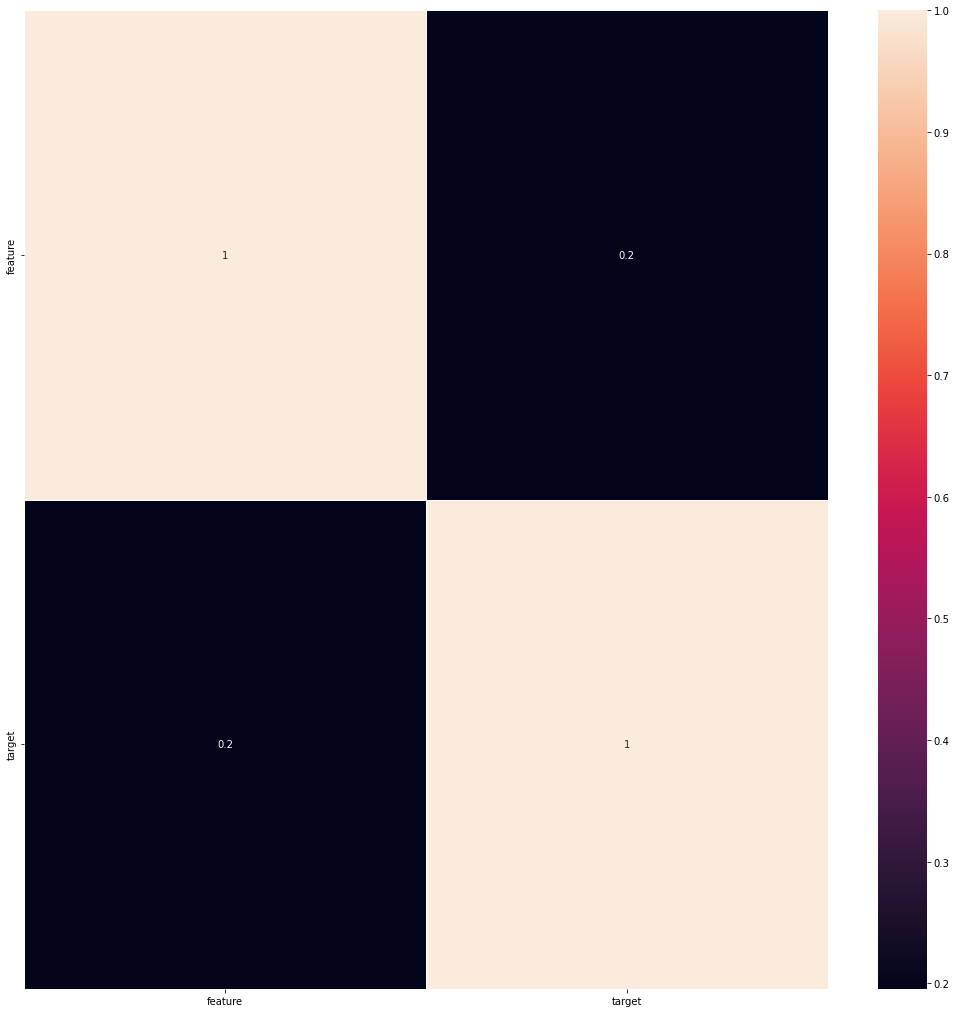

In [3]:
def corr():
    fig, ax = plt.subplots(figsize=(18,18)) 
    sns.heatmap(data=main_data.corr(), annot=True, linewidths=.5, ax=ax)
    plt.show()
corr()

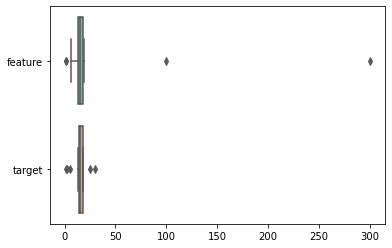

In [4]:
def box():
    sns.boxplot(data=main_data, orient="h", palette="Set2")
box()

In [5]:
def Get_IQR(data):
    quartiles = np.quantile(data, [.25, .75])
    iqr = (quartiles[1] - quartiles[0])
    print(f'Q1 = {quartiles[0]}, Q3 = {quartiles[1]}, IQR = {iqr}')
    return {
        "Q1": quartiles[0],
        "Q3": quartiles[1],
        "IQR": iqr
    }

In [6]:
def ReplaceOutlier(x, replacement_value, quatiles, scale):
    if x < quatiles["Q1"] - scale * quatiles["IQR"]  or x > quatiles["Q3"] + scale * quatiles["IQR"]:
        return replacement_value
    return x

In [7]:
main_data['feature'] = main_data['feature'].apply(ReplaceOutlier, convert_dtype=True, replacement_value=data.median(), scale=1, quatiles=Get_IQR(data))
main_data['target'] = main_data['target'].apply(ReplaceOutlier, convert_dtype=True, replacement_value=data.median(), scale=1, quatiles=Get_IQR(data))

Q1 = 13.0, Q3 = 18.0, IQR = 5.0
Q1 = 13.0, Q3 = 18.0, IQR = 5.0


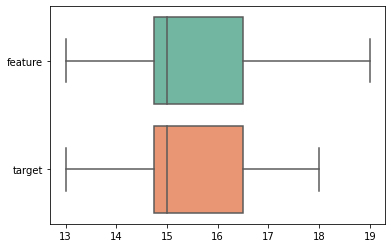

In [8]:
box()

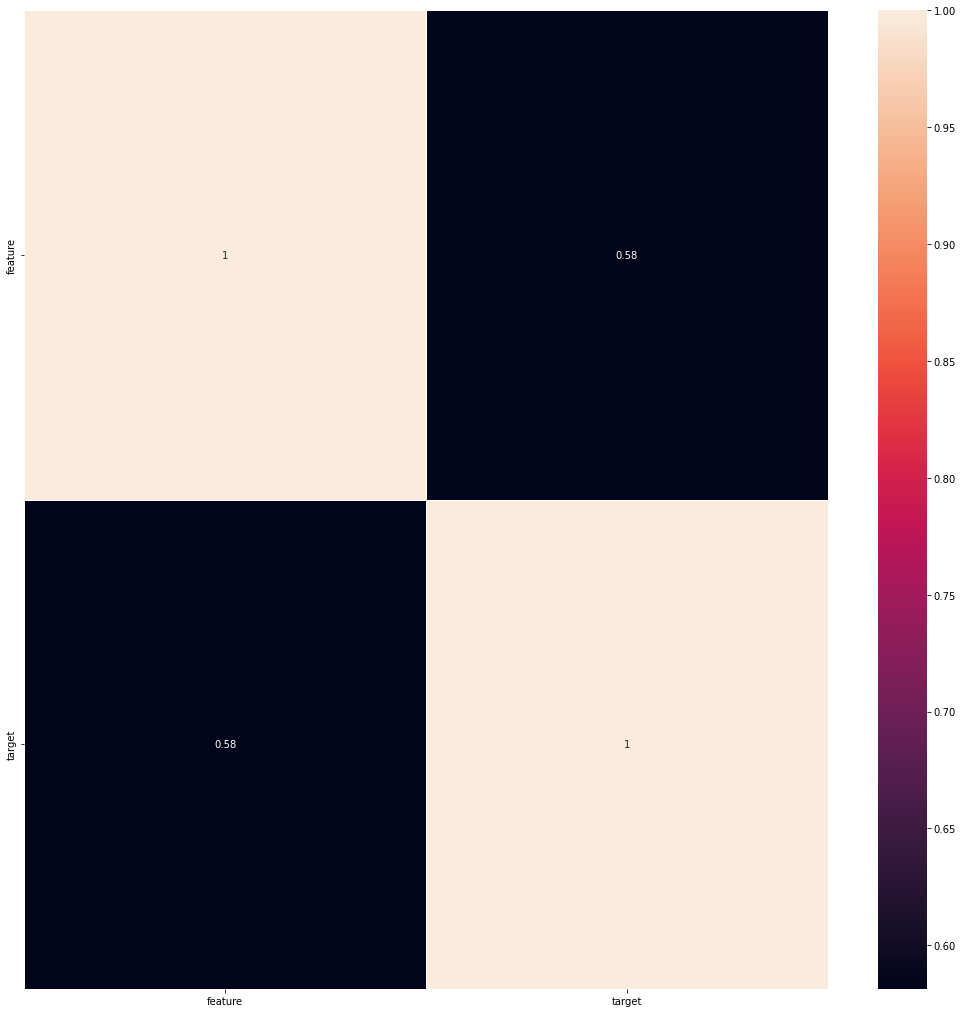

In [9]:
corr()